# このファイルについて
## 頭が悪いコードなので直してくれるとうれしいな( *´艸｀)

擾乱に対する位置制御のために必要な燃料を推算します。

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math

In [123]:
MU = 3.986*10**5#地球重力定数[km^3/s^2]
R_po = 6600.#パーキング軌道半径[km]
Delta_i = 30.#種子島の緯度[deg]
PI = np.pi
J2 = 1082.628*10**(-6)#J2帯状調和関数係数
R_e = 6

In [124]:
alpha = 28.58
alpha = np.deg2rad(alpha)
delta_moon = 102.67*np.cos(alpha)*np.sin(alpha)
print(delta_moon)
gamma = 23.44
gamma = np.deg2rad(alpha)
delta_sun = 40.17*np.cos(gamma)*np.sin(alpha)
print(delta_sun)

43.13106201760243
19.216011456044555


# 再突入のΔｖ概算
## to do
大気とか概算なので、ちゃんと後でどっかのデータ引用した方がよい

おそらく高度20㎞とかでパラシュート展開するのかな
## 大気圏内の支配方程式
\begin{align*}
\frac{dv}{dt} = \ddot{x} =-\frac{D}{m} - g\sin\gamma \\
v\frac{d\gamma}{dt} = \frac{L}{m} - g\cos\gamma + \frac{v^2}{r}\cos{\gamma}
\end{align*} 

In [125]:
G = 9.81 #重力加速度[m/s^2]
R_earth = 6378 #地球の半径[km]
SCALE_HEIGHT = 8.432#スケールハイト[km]
RHO_0 = 1.225#標準大気密度[kg/m^3]
H_reEntry = 200 #大気圏高度[km]
M_earth = 5.9724*10**24
## すまん、ここ詰める必要あるな
v_reEntry = 8.0 #再突入の速度(一例)[km/s]
gamma_reEntry = -0.001#再突入時の経路角(結構浅め)[deg]

#機体によるので、あとで
M_capcell = 16.3 #はやぶさ参照[kg]
A = 0.2 #ハヤブサよりちょい大きめ[kg]
Rn = 0.2#てきとー

#なんかを参照
Cd = 2.2
Cl = 0.7
DT = 0.01#刻み
def dominant_eq(D,L,gamma,v,r, M=M_capcell):
    gamma_rad = np.deg2rad(gamma)
    dot_r = v*np.sin(gamma_rad)
    dot_v = -D/M*10**3-G*math.sin(gamma_rad)*10**(-3)
    dotgamma_rad = L/(M*v)*10**3-G*math.cos(gamma_rad)/v*10**(-3)+v*math.cos(gamma_rad)/r
    dot_gamma = np.rad2deg(dotgamma_rad)
    return dot_r,dot_v,dot_gamma

def get_density(h):
    return RHO_0*np.exp(-h/SCALE_HEIGHT)

def get_Drag_Lift(v,rho, S=A):
    D = 1/2*rho*v**2*S*Cd
    L = 1/2*rho*v**2*S*Cl
    return D,L

def f(h, v, gamma):
    rho = get_density(h)
    D,  L = get_Drag_Lift(v, rho)
    r = h + R_earth
    dot_r, dot_v, dot_gamma = dominant_eq(D, L, gamma, v, r)
    return np.array([dot_r, dot_v, dot_gamma])

def re_entry(v_reEntey,gamma_reEntry):
    h = H_reEntry
    v = v_reEntry
    gamma = gamma_reEntry
    heating_rate = 1.35*10**(-8)*np.sqrt(get_density(h)/Rn)*(v*10**3)**3.04 *10
    t = 0
    t_lst = [t]
    h_lst = [h]
    v_lst = [v]
    gamma_lst= [gamma]
    heating_rate_lst = [heating_rate]
    while 0 <= h <= H_reEntry:
        k1_vector = f(h, v, gamma)*DT
        k1_r, k1_v, k1_gamma = k1_vector[0], k1_vector[1], k1_vector[2]
        k1_h = k1_r
        
        k2_vector = f(h+k1_h/2, v+k1_v/2, gamma+k1_gamma/2)*DT
        k2_r, k2_v, k2_gamma = k2_vector[0], k2_vector[1], k2_vector[2]
        k2_h = k2_r

        k3_vector = f(h+k2_h/2, v+k2_v/2, gamma+k2_gamma/2)*DT
        k3_r, k3_v, k3_gamma = k3_vector[0], k3_vector[1], k3_vector[2]
        k3_h = k3_r

        k4_vector = f(h+k3_h, v+k3_v, gamma+k3_gamma)*DT
        k4_r, k4_v, k4_gamma = k4_vector[0], k4_vector[1], k4_vector[2]
        k4_h = k4_r

        delta_r_euqual_h = (k1_r + 2.*k2_r + 2.*k3_r + k4_r)/6.
        delta_v = (k1_v + 2.*k2_v + 2.*k3_v + k4_v)/6.
        delta_gamma = (k1_gamma + 2.*k2_gamma + 2.*k3_gamma + k4_gamma)/6
        ####################################
        h += delta_r_euqual_h
        v += delta_v
        gamma += delta_gamma
        t += DT
        heating_rate = 1.35*10**(-8)*np.sqrt(get_density(h)/Rn)*(v*10**3)**3.04 *10
        t_lst.append(t)
        h_lst.append(h)
        v_lst.append(v)
        gamma_lst.append(gamma)
        heating_rate_lst.append(heating_rate)
    if h_lst[-1] >= H_reEntry:
        #大気に弾かれた場合
        print("カプセル帰ってこず。。。。")
    else:
        print("カプセル帰還")
        return t_lst, h_lst, v_lst, gamma_lst, heating_rate_lst

In [126]:
import matplotlib as mpl
import matplotlib.font_manager as fm

font = {"family":"Noto Sans CJK JP"}
mpl.rc('font', **font)

#fm.findSystemFonts()

カプセル帰還


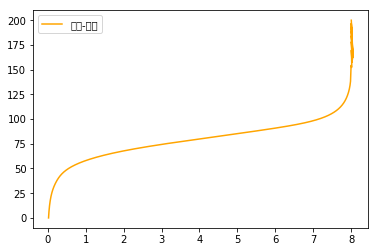

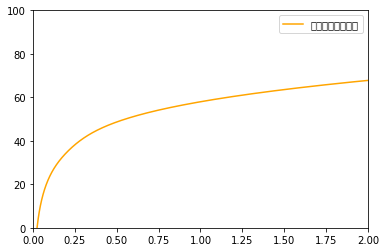

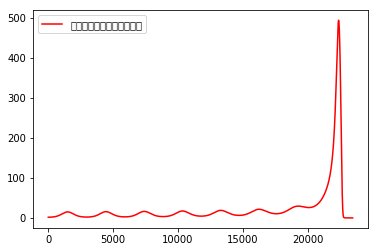

In [127]:
a, b, c, d, e = re_entry(v_reEntry, gamma_reEntry)
plt.plot(c, b, color='orange',label='高度-速度')
plt.legend()
plt.show()

plt.plot(c, b, color='orange', label='より小さいところ')
plt.xlim(0,2)
plt.ylim(0,100)
plt.legend()
plt.show()

plt.plot(a, e, color='red',label='空力加熱率高すぎいいいい')
plt.legend()
plt.show()

# 必要燃料@帰還時の水酸
## 方針
1. 大気圏突入速度を決める←多分、決め打ち
2. そこから逆算して、アポジキック(逆噴射)決定

## 使う方程式
以下
\begin{align*}
\alpha = \frac{rv^2}{\mu}
\end{align*}
とすると、
### 離心率の決定
\begin{align*}
e = \sqrt{(\alpha-2)\alpha\cos^2\gamma+1}
\end{align*}
### 遷移軌道時の軌道長半径の決定
\begin{align*}
r_a = \frac{1+e\cos\theta}{1-e^2}r
\end{align*}
この辺いらんな。。。。一応デバッグ要員として

角運動量一定より、
\begin{align*}
v_{@apo} = \frac{h}{r_{@apo}} = \frac{r_{entry}v_{entry}\cos\gamma_{entry}}{r_{circuit}}
\end{align*}
が燃料噴射直後の速さなので、
\begin{align*}
\Delta v = v_{circuit}-v_{@apo}
\end{align*}
が減速量で、燃料を最終質量$m_f$(カプセル重量から引っ張ってくる)から逆算して
\begin{align*}
m_{prop_{@return}} = m_f\left(e^{\frac{\Delta v}{gI_{sp}}}-1\right)
\end{align*}


In [128]:
def get_prop(r0, r, v, gamma, mf=1000, Isp=315):
    """
    ある点の情報がわかれば、遠地点(仮)での推進剤重量がわかり幸せになれる
    arg:
        r0[km] 周回軌道半径(遠地点(仮))
        r[km] ある地点でのr
        v[km/s] ある地点での速さ
        gamma[deg] ある地点での経路角
        mf[kg] 最終重量(本体ごと突っ込む)
                default:1000kg(はやぶさ参照)
        Isp[s] 燃料のIsp
                default:315(四酸化二窒素-ヒドラジン)
        
    return:
        mp[kg] 必要燃料重量
                
    
    """
    gamma = np.deg2rad(gamma)
    alpha = r*v**2/MU#無次元数の何か
    
    #離心率の決定(楕円軌道前提)
    eccentricity = np.sqrt((alpha-2)*alpha*(np.cos(gamma))**2+1)
    print("離心率は{}".format(eccentricity))
    
    #真近点離角
    tan_true_anomaly = alpha*np.sin(gamma)*np.cos(gamma)/(alpha*(np.cos(gamma))**2-1)
    true_anomaly = math.atan(tan_true_anomaly)
    print("真近点離角は{}".format(true_anomaly))
    
    #半長軸の決定
    semi_major_axis = (1+eccentricity*np.cos(true_anomaly))*r/(1-eccentricity**2)
    print("半長軸の長さ{}[km]".format(semi_major_axis))
    
    #燃料噴出"前"の速さ
    print("減速前の速さ{}[km/s]".format(np.sqrt(MU/r0)))
    #燃料噴出"直"後の速さ
    v0 = r*v*np.cos(gamma)/r0
    print("減速後の速さ{}[km/s]".format(v0))
    
    delta_v = np.sqrt(MU/r0) - v0
    print("減速量{}[km/s]".format(delta_v))
    
    mp = mf*(np.exp(delta_v*10**3/G/Isp) -1)
    print("燃料は{}[kg]".format(mp))
    
    return None

r0 = R_earth + 1800
r1 = R_earth + 200
get_prop(r0, r1, v=v_reEntry, gamma=gamma_reEntry)

離心率は0.0561766208662641
真近点離角は-0.00032813934893813617
半長軸の長さ6969.524305703232
減速前の速さ6.981441352281318
減速後の速さ6.434825139641099
減速量0.5466162126402194
燃料は193.49963838063934[kg]


In [129]:
#擾乱の永年項を計算
#計算量多めなので、後で直す
def gravity_perturbation_moon(r, i):
    """
    月の重力による擾乱
    
    arg:
    r(float) 軌道長半径(円軌道の時は半径)[km]
    i(float) 軌道傾斜角[deg]
    
    return:
    dot_omega_moon(float) 近地点引数の変化[deg/day]
    dot_Omega_moon(float) 昇交点赤経の変化[deg/day]
    
    """
    i = np.deg2rad(i)
    n = np.sqrt(MU/r**3) #[rad/s]
    n *= 60*60*24 #[rad/day]
    n /= 2*PI#[周回数/day]
    dot_Omega_moon = -0.00338*np.cos(i)/n
    dot_omega_moon = 0.00169*(4-5*(np.sin(i))**2)/n
    return dot_Omega_moon, dot_omega_moon

def gravity_perturbation_sun(r, i):
    """
    太陽の重力による擾乱
    
    arg:
    r(float) 軌道長半径(円軌道の時は半径)[km]
    i(float) 軌道傾斜角[deg]
    
    return:
    dot_omega_sun(float) 近地点引数の変化[deg/day]
    dot_Omega_sun(float) 昇交点赤経の変化[deg/day]
    
    """
    i = np.deg2rad(i)
    n = np.sqrt(MU/r**3) #[rad/s]
    n *= 60*60*24 #[rad/day]
    n /= 2*PI#[周回数/day]
    dot_Omega_sun = -0.00154*np.cos(i)/n
    dot_omega_sun = 0.00077*(4-5*((np.sin(i))**2))/n
    return dot_Omega_sun, dot_omega_sun

print(gravity_perturbation_sun(6700, 28))

(-8.58944949611711e-05, 0.0001409600776584566)


In [130]:
class Orbit:
    """なんか軌道わかるとうまくいくやつ()
    to do
    外乱制御用のΔV
    """
    
    def __init__(self, r_tgt):
        """とりあえず円周回軌道半径だけ。。。"""
        self.r_tgt = r_tgt # radius of orbit
        self.delta_v_peri = None
        self.delta_v_apo = None
        self.delta_v = None
        
        self.reentry_height = 100 #地球の大気圏高度[km]
        self.v_tgt = None
    def get_delta_v_peri(self):
        """近地点でのΔv"""
        r_tgt = self.r_tgt
        v_po = np.sqrt(MU/R_po)
        v_peri_trans = np.sqrt(2*MU*r_tgt/R_po/(R_po+r_tgt))
        self.delta_v_peri = v_peri_trans - v_po

    def get_delta_v_apo(self):
        """遠地点でのΔv"""
        r_tgt = self.r_tgt
        self.v_tgt = np.sqrt(MU/r_tgt)
        v_apo_trans = np.sqrt(2*MU*R_po/r_tgt/(R_po+r_tgt))
        self.delta_v_apo = self.v_tgt-v_apo_trans
    
    def j2(self):
        """
        外乱J2項考えましょうね～～～～～～～～～～
        """
    
    def get_delta_v(self):
        """Δv全部"""
        self.get_delta_v_peri()
        self.get_delta_v_apo()
        self.delta_v = self.delta_v_apo+self.delta_v_peri
        print("Delta V: {0} [km/s]".format(self.delta_v))
        print("V at tgt: {}[km/s]".format(self.v_tgt))

In [131]:
orb = Orbit(7200.)
orb.get_delta_v()

Delta V: 0.3306925582501039 [km/s]
V at tgt: 7.440504761849906[km/s]


# 空気抵抗による落下の推算

空気抵抗による高度落下を計算。  
\begin{align*}
\frac{dr}{dt} = -\frac{\rho V C_d A_s r}{m} = -\rho \frac{C_d A_s}{m}\sqrt{GMr}
\end{align*}

In [132]:
def get_drdt(r,Cd,As,m):
    """ r,drの単位は[km] """
    rho = get_density(r-R_earth)
    return (-rho*Cd*As*np.sqrt(G*M_earth*r*1000)/m) /1000

def solve_air_drag_eq(r0,dt=10**1,nstep=10**5,Cd_sat=2.2,As=20.,m_sat=500.):
    r_rev = [r0]
    for i in range(nstep):
        dr = get_drdt(r_rev[i],Cd_sat,As,m_sat)*dt
        new = r_rev[i] + dr
        if new > 0:
            r_rev.append(new)
        else:
            r_rev.append(R_earth)
    return r_rev[1:]

In [133]:
dt = 10**4
nstep = 10**4
r_rev = solve_air_drag_eq(380+R_earth,dt=dt,nstep=nstep)

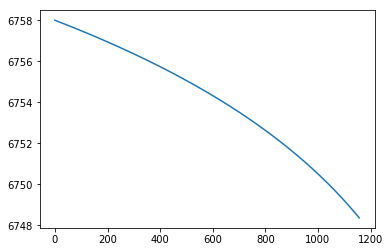

In [134]:
t = np.arange(0,nstep*dt,dt)/3600/24 # 単位はday
plt.plot(t,r_rev)

In [135]:
r_rev = solve_air_drag_eq(300+R_earth,dt=dt,nstep=nstep)